In [31]:
""" Scratch file for testing code related to preprocessing and augmenting data."""

' Scratch file for testing code related to preprocessing and augmenting data.'

In [32]:
import os
import cv2
import numpy as np;
import matplotlib.pyplot as plt
import torch 
import torchvision.transforms as transforms

In [33]:
img_dir = "small_data_3d/original/train"
mask_dir = "small_data_3d/ground_truth/train"
img_files = os.listdir(img_dir)
mask_files = os.listdir(mask_dir)

In [34]:
# sample image and mask
k = 24
image = np.load(os.path.join(img_dir, img_files[k]))
mask = np.load(os.path.join(mask_dir, mask_files[k]))
depth, height, width = image.shape
print(image.shape, mask.shape)

(5, 512, 512) (5, 512, 512)


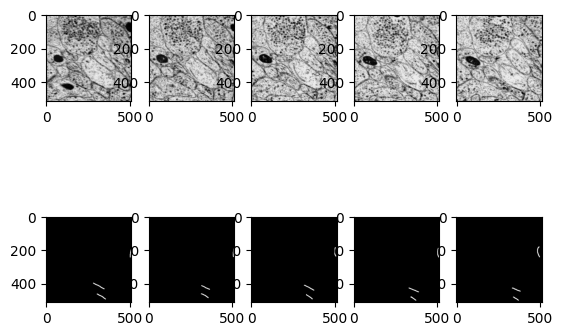

In [35]:
fig, ax = plt.subplots(2, depth)
for i in range(depth):
    ax[0, i].imshow(image[i], cmap="gray")
    ax[1, i].imshow(mask[i], cmap="gray")
plt.show()

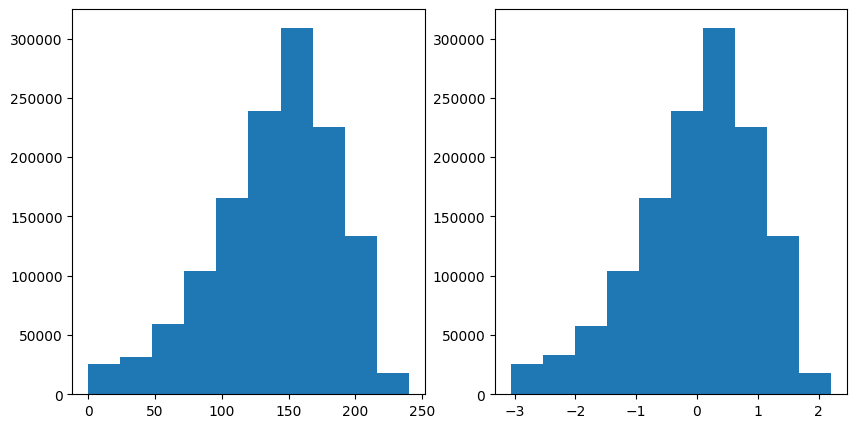

In [36]:
image_preprocessed = (image - image.mean()) / image.std()
image_tensor = torch.tensor(image_preprocessed).float()
image_tensor.dtype
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(image.flatten())
ax[1].hist(image_preprocessed.flatten())
plt.show()

In [37]:
mask_tensor = torch.tensor(mask).float()
print(mask_tensor.shape)
print(mask_tensor.dtype)

torch.Size([5, 512, 512])
torch.float32


In [38]:
torch.nn.functional.one_hot(mask_tensor.long(), num_classes=2).shape

torch.Size([5, 512, 512, 2])

In [39]:
# calculate focal loss
from dataset import SliceDataset
import numpy as np
import os
# Define directories
x_train_dir="small_data_3d/original/train"
y_train_dir="small_data_3d/ground_truth/train"
x_valid_dir="small_data_3d/original/valid"
y_valid_dir="small_data_3d/ground_truth/valid"
x_test_dir="small_data_3d/original/test"
y_test_dir="small_data_3d/ground_truth/test"
model_folder = "models"
sample_preds_folder = "results"

depth, height, width = np.load(os.path.join(x_train_dir, os.listdir(x_train_dir)[0])).shape
# Get train and val dataset instances
train_dataset = SliceDataset(x_train_dir, y_train_dir, image_dim = (width, height), augmentation=None)
valid_dataset = SliceDataset(x_valid_dir, y_valid_dir, image_dim = (width, height))

In [40]:
train_dataset[0][1].shape

torch.Size([2, 5, 512, 512])

In [41]:
# Initialize loss function
from tqdm import tqdm
import torch
smushed_labels = None
# track progress with tqdm
for i in tqdm(range(len(train_dataset))):
    if smushed_labels is None: smushed_labels = train_dataset[i][1].to(torch.int64)
    else: smushed_labels = torch.cat([smushed_labels, train_dataset[i][1].to(torch.int64)])
class_counts = torch.bincount(smushed_labels.flatten())
total_samples = len(train_dataset) * 512 * 512
w1, w2 = 1/(class_counts[0]/total_samples), 1/(class_counts[1]/total_samples)

  0%|          | 0/145 [00:00<?, ?it/s]

 15%|█▌        | 22/145 [00:02<00:12, 10.06it/s]


KeyboardInterrupt: 

In [ ]:
from models import *
model = UNet()

In [42]:
input, label = train_dataset[0]
input = input.unsqueeze(0)
print(input.shape, label.shape)

torch.Size([1, 5, 512, 512]) torch.Size([2, 5, 512, 512])


In [43]:
model(input)

RuntimeError: Given groups=1, weight of size [64, 32, 1, 3, 3], expected input[1, 1, 5, 512, 512] to have 32 channels, but got 1 channels instead